# -----------------   Union all csv files from data folder ---------------------------

In [1]:
import os
import pandas as pd
import re
import nltk
import numpy as np

In [2]:
# Insert datapath
datapath = os.getcwd() +'/data'

In [3]:
#List wanted files to combine, now just csv files
files = [file for file in os.listdir(datapath) if file.endswith('.csv')]

In [5]:
#Lets make datafame from the first file
data = pd.read_csv(datapath+'/{}'.format(files[0]))

In [6]:
#lets union all csv files and then save file as all.csv
for i in range(1,len(files)):
    data = data.append(pd.read_csv(datapath+'/{}'.format(files[i])))
data.to_csv('all.csv')

In [9]:
len(data)

54518

# ----------------- TRANSFORMATIONS FOR DIFFERENT NEEDS ------------------------

In [10]:
#### lets preprocess all.csv to make it nicer
df = pd.read_csv('all.csv')

#combine title and text
df['text_and_title'] = df['structs.text_title'] + "." + df['word']

# make label fasttext format
df['label'] = '__label__'+df['structs.text_sect']

#get rid of not needed columns
df_final = df[['label','text_and_title']]

# remove punctuation
df_final['punctuation_removed'] = df_final['text_and_title'].astype(str).apply(lambda row: re.sub(r'[^\w\s]',' ',row))

#remove numbers
df_final['text_and_title_non_number'] = df_final['text_and_title'].str.replace('\d+', '')

#lowercase
df_final['lowered'] = df_final['punctuation_removed'].apply(lambda row: str.lower(row))

#tokenize
df_final['tokenized'] = df_final['lowered'].apply(lambda r: nltk.word_tokenize(r))

# get char and word counts
df_final['char_count'] = df_final.lowered.replace(' ','').map(len)
df_final['word_count'] = df_final.tokenized.map(len)

# Save this to csv
df_final.to_csv('all_preprocessed_no_filtering.csv')

df_ft = df[['label','text_and_title']]
# Save in the right format for FastText training
df_ft.to_csv('fasttext_embeddings_train.txt', sep='\t', index = False, header = False)
df_ft.iloc[0:int(len(df)*0.8)].to_csv('train.txt', sep='\t', index = False, header = False)
df_ft.iloc[int(len(df)*0.8):int(len(df)*0.9)].to_csv('test.txt', sep='\t', index = False, header = False)

F:\Anaconda3\envs\FinBertTrainEnv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
F:\Anaconda3\envs\FinBertTrainEnv\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
F:\Anaconda3\envs\FinBertTrainEnv\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

# ---------------------------- Filtering for BERT model ---------------------------------

In [11]:
#function to cut dataframe by the amount of words in message
def cut_df_by_word_count(df,min_words, max_words):
    df = df[df.word_count.between(min_words,max_words)]
    return df

def cut_df_by_topic_counts(df, column, min_occurances, max_occurances):
    value_counts = test_df['{}'.format(column)].value_counts()
    a = value_counts.between(min_occurances,max_occurances)
    b = [a.index[i] for i,x in enumerate(a.index) if a[i]]
    df = df[df['{}'.format(column)].isin(b)]
    return df

In [12]:
len(df_final)

54518

In [13]:
# cut test_df by word_count eg.
# here only take messages that have words between 50 to 500
# test_df = cut_df_by_word_count(messages, 50, 500)
lower_word_limit = 50
upper_word_limit = 500

test_df = cut_df_by_word_count(df_final, 50, 500)

In [10]:
## if you want you can also cut df by the amount of samples in topic
## here for example we cut topics keep only topics that have between 2000 to 20 000 messages
#test_df = cut_df_by_topic_counts(test_df, 'label',2000, 20000)
#lower_topic_count = 2000
#upper_topic_count = 20000
#test_df = cut_df_by_topic_counts(test_df, 'label',lower_topic_count, upper_topic_count)

In [15]:
test_df.to_csv('all_preprocessed_filtered.csv')

In [16]:
test_df['label'].value_counts()

__label__Yhteiskunta                      5244
__label__Suhteet                          3229
__label__Perhe                            3189
__label__Työ ja opiskelu                  2481
__label__Terveys                          2477
__label__Lemmikit                         2151
__label__Viihde ja kulttuuri              1818
__label__Paikkakunnat                     1790
__label__Talous                           1748
__label__Urheilu ja kuntoilu              1691
__label__Matkailu                         1676
__label__Nuoret                           1421
__label__Koti ja rakentaminen             1370
__label__Ajanviete                        1277
__label__Tiede ja teknologia              1146
__label__Ajoneuvot ja liikenne            1024
__label__Ryhmät                            994
__label__Ruoka ja juoma                    994
__label__Muoti ja kauneus                  861
__label__Harrastukset                      741
__label__Suomi24                           160
__label__Tori

In [17]:
len(test_df)

37517

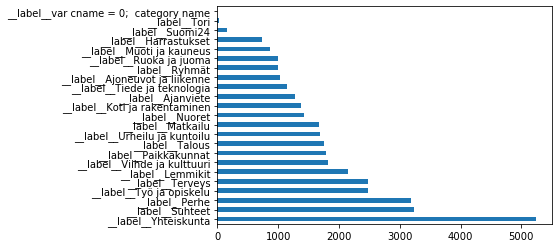

In [18]:
pd.value_counts(test_df['label']).plot.barh()

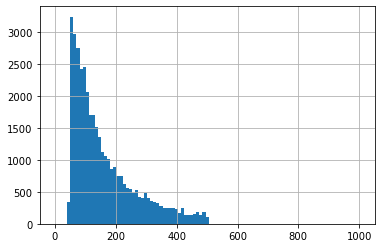

In [19]:
test_df.word_count.hist(bins=np.linspace(0,1000,100))